In [1]:
import keras
import numpy
import matplotlib.pyplot as plotter
import PIL
import json
import time
import tensorflow
from PIL import ImageDraw

In [2]:
Num_Data = 2000 # Maximum is 3609

resultant_aspect = 224

labels = numpy.full((Num_Data, 1), 0)
images = numpy.full((Num_Data, resultant_aspect, resultant_aspect, 3), 0)

# Contains the highlighted points
density_maps = numpy.full((Num_Data, resultant_aspect, resultant_aspect), 0)

In [3]:
# Call this if you want to reload the images for the first time
def Load_Images(Num_Data, images, labels, density_maps):

    start_time = time.time()

    # Load the json
    for i in range(Num_Data):
        
        # Create the name of the file with leading 0s
        name_str = str(i + 1).zfill(4)
        
        data = None

        # Load the json
        with open("Json/" +  name_str + ".json") as f:
          data = json.load(f)

        labels[i] = data["human_num"]

        image_load = PIL.Image.open("Images/" + data["img_id"])
        
        width, height = image_load.size
        
        # Resize the image
        images[i] = numpy.asarray(image_load.resize((resultant_aspect, resultant_aspect)))[:,:,0:3]
        
        img = PIL.Image.new("RGB", (resultant_aspect, resultant_aspect))
        draw = ImageDraw.Draw(img)
        
        resize_x = resultant_aspect / width
        resize_y = resultant_aspect / height
        
        # Run through the list of points
        for points in data["points"]:
            # Draw each circle on the density map
            x = points[0] * resize_x
            y = points[1] * resize_y
            draw.ellipse((x - 2, y - 2, x + 2, y + 2), fill=(255, 0, 0), outline=(0, 0, 0))
        
        density_maps[i] = numpy.asarray(img)[:, :, 0]
        
        if i % 200 == 0:
            print(i, " images loaded so far!")

    print("Time taken: ", time.time() - start_time)

In [4]:
Load_Images(Num_Data, images, labels, density_maps)

0  images loaded so far!
200  images loaded so far!
400  images loaded so far!


C:\ProgramData\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:792: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


600  images loaded so far!
800  images loaded so far!
1000  images loaded so far!
1200  images loaded so far!
1400  images loaded so far!
1600  images loaded so far!
1800  images loaded so far!
Time taken:  417.8150873184204


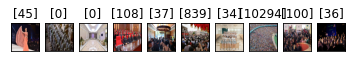

In [5]:
# Show 10 images from the training data
fig, axis = plotter.subplots(1, 10)

for i in range(10):
        
    axis[i].imshow(images[i])
    axis[i].title.set_text(str(labels[i]))
    axis[i].get_xaxis().set_visible(False)
    axis[i].axes.get_yaxis().set_visible(False)

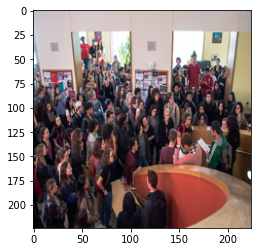

In [6]:
plotter.imshow(images[8])

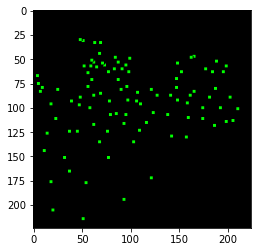

In [7]:
actual_density = numpy.full((resultant_aspect, resultant_aspect, 3), 0)

actual_density[:,:,1] = density_maps[8]

plotter.imshow(actual_density)

In [8]:
# Load the vgg16 pretrained model
vgg16 = tensorflow.keras.applications.VGG16(include_top=False, input_shape=(224, 224, 3))

# View the summary of the vgg16 pretrained model
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [9]:
model = keras.Sequential()

# Rebuild the vgg16 layers without the max pooling

model.add(keras.layers.Input((224, 224, 3)))

model.add(keras.layers.Conv2D(64,kernel_size=(3,3),padding="same", activation="relu"))

model.add(keras.layers.Conv2D(128, kernel_size=(3,3), padding="same", activation="relu"))

model.add(keras.layers.Conv2D(256, kernel_size=(3,3), padding="same", activation="relu"))

model.add(keras.layers.Conv2D(512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(keras.layers.Conv2D(512, kernel_size=(3,3), padding="same", activation="relu"))
    
# Final layer to get the density map
model.add(keras.layers.Conv2D(128, (3, 3), padding="same", activation='relu'))
model.add(keras.layers.Conv2D(1, (3, 3),  padding="same", activation='relu'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 128)     73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 256)     295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 224, 224, 512)     1180160   
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 224, 224, 512)     2359808   
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 224, 224, 128)     589952    
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 224, 224, 1)       1

In [10]:
model.compile(optimizer="Adam", loss="mse", metrics=["mean_squared_error"])

In [11]:
my_callbacks = [keras.callbacks.ModelCheckpoint("my_weights.h5", monitor="val_loss", save_best_only=False)]

start_time = time.time()

history = model.fit(images, density_maps, batch_size=40, epochs=20, validation_split=0.2, callbacks=my_callbacks)

print("Time taken: ", time.time() - start_time)

Epoch 1/20
40/40 [==============================] - 13608s 340s/step - loss: 29038.4434 - mean_squared_error: 29038.4512 - val_loss: 2149.1287 - val_mean_squared_error: 2149.1284
Epoch 2/20
40/40 [==============================] - 13726s 343s/step - loss: 1953.6360 - mean_squared_error: 1953.6357 - val_loss: 2101.1829 - val_mean_squared_error: 2101.1831
Epoch 3/20
40/40 [==============================] - 13978s 349s/step - loss: 1989.8969 - mean_squared_error: 1989.8967 - val_loss: 2187.6323 - val_mean_squared_error: 2187.6323
Epoch 4/20
40/40 [==============================] - 13335s 333s/step - loss: 1950.3726 - mean_squared_error: 1950.3727 - val_loss: 2141.1072 - val_mean_squared_error: 2141.1072
Epoch 5/20
40/40 [==============================] - 13286s 332s/step - loss: 1891.6284 - mean_squared_error: 1891.6284 - val_loss: 2165.5396 - val_mean_squared_error: 2165.5396
Epoch 6/20
40/40 [==============================] - 13584s 340s/step - loss: 1889.0459 - mean_squared_error: 1889

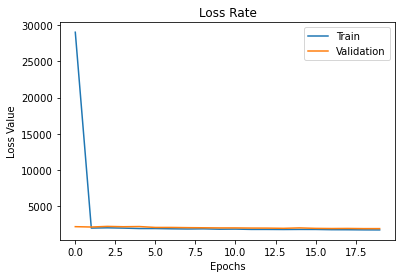

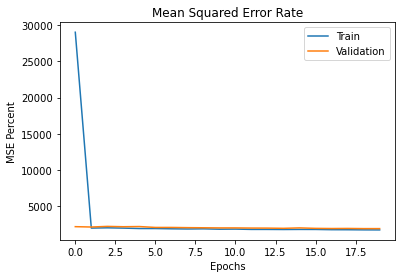

In [12]:
# Plot the loss value
plotter.plot(history.history["loss"])
plotter.plot(history.history["val_loss"])
plotter.ylabel("Loss Value")
plotter.xlabel("Epochs")
plotter.legend(["Train", "Validation"])
plotter.title("Loss Rate")
plotter.show()

# Plot the mse value
plotter.plot(history.history["mean_squared_error"])
plotter.plot(history.history["val_mean_squared_error"])
plotter.ylabel("MSE Percent")
plotter.xlabel("Epochs")
plotter.legend(["Train", "Validation"])
plotter.title("Mean Squared Error Rate")
plotter.show()

(224, 224, 4)

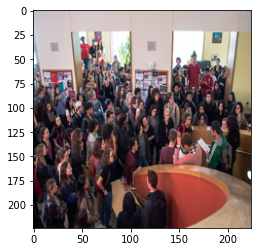

In [13]:
predict_image = numpy.full((resultant_aspect, resultant_aspect, 4), 255)
predict_image[:,:,0:3] = images[8][:,:,0:3]

plotter.imshow(predict_image)

predict_image.shape

In [14]:
# Check the evaluation of the model with the first 10 data
# Probably will give the same rmse
result = model.evaluate(images[0:9], density_maps[0:9])

1/1 [==============================] - 0s 162ms/step - loss: 2003.4106 - mean_squared_error: 2003.4105


In [15]:
# Perform the prediction on the first 10 data to check if it works
prediction = model.predict(images[0:9])

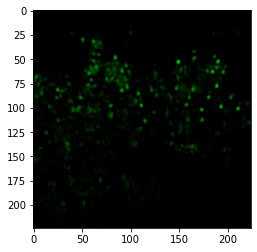

In [16]:
# Create the predicted density map
predicted_density = numpy.full((resultant_aspect, resultant_aspect, 3), 0)

predicted_density[:,:,1] = prediction[8][:,:,0]

plotter.imshow(predicted_density)

In [17]:
print("Mean: ", numpy.mean(prediction[8][:,:,0]))
print("Mean: ", numpy.max(prediction[8][:,:,0]))

Mean:  4.8291006
Mean:  235.58264


In [18]:
numpy.mean(density_maps[8])

4.523078762755102

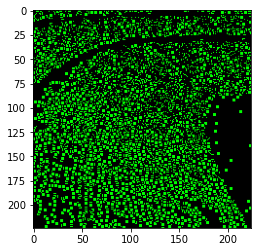

In [19]:
actual_density = numpy.full((resultant_aspect, resultant_aspect, 3), 0)

actual_density[:,:,1] = density_maps[7]

plotter.imshow(actual_density)

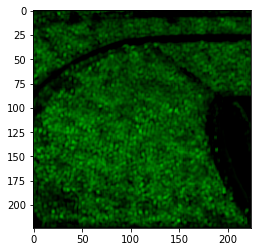

In [20]:
# Create the predicted density map
predicted_density = numpy.full((resultant_aspect, resultant_aspect, 3), 0)

predicted_density[:,:,1] = prediction[7][:,:,0]

plotter.imshow(predicted_density)

In [21]:
prediction_images = numpy.full((1, resultant_aspect, resultant_aspect, 3), 0)

image_load = PIL.Image.open("Images/3734.jpg")        
width, height = image_load.size

# Resize the image
prediction_images[0] = numpy.asarray(image_load.resize((resultant_aspect, resultant_aspect)))[:,:,0:3]

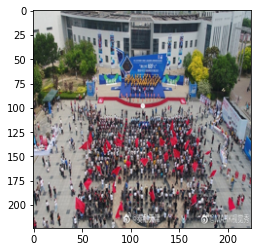

In [22]:
plotter.imshow(prediction_images[0])

In [23]:
prediction = model.predict(prediction_images)

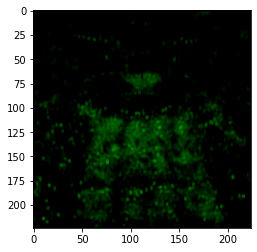

In [24]:
# Create the predicted density map
predicted_density = numpy.full((resultant_aspect, resultant_aspect, 3), 0)

predicted_density[:,:,1] = prediction[0][:,:,0]

plotter.imshow(predicted_density)